In [138]:
import os
import glob
import yaml  # You'll need to install the PyYAML library for YAML parsing
from cloudmesh.common.FlatDict import FlatDict
from pprint import pprint

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the directory where you want to start the search
start_directory = 'project/'

# Initialize an empty dictionary to store the results
result = []

# Use a recursive search to find all files matching the pattern
for root, dirs, files in os.walk(start_directory):
    for file in files:
        if file.startswith('result') and file.endswith('.out'):
            file_path = os.path.join(root, file)
            with open(file_path, 'r') as f:
                lines = f.readlines()
                csv_lines = [line.strip() for line in lines if line.startswith("# csv")]
                try:
                    result_line = [line.replace(":::MLLOG", "").strip() for line in lines if line.startswith(":::MLLOG") and '"result"' in line][0]
                    result_line = eval(result_line)
                except:
                    result_line = None
                csv_dict = {}
                for line in csv_lines[1:]:  # Skip the header line
                    line_parts = line.split(',')
                    timer_key = line_parts[1]
                    csv_dict[timer_key] = float(line_parts[3])
            
                if csv_lines:
                    config_path = os.path.join(root, 'config.yaml')
                    config = FlatDict()
                    try:
                        config.loadf(filename=config_path)
                    except:
                        config = None
                    # filter only the "experiment." values

                    filtered = {key.replace("experiment.",""): value 
                                for key, value in dict(config).items() if key.startswith('experiment.')}
                    entry = {
                        'name': file
                    }
                    entry.update(csv_dict)
                    entry.update(filtered)
                    entry.update({"result": result_line})
                    result.append(entry)


# Print the dictionary with the results, including the config
# for filename, data in result_dict.items():
#     print(f'File: {filename}')
#     print('CSV Lines:')
#     for line in data['csv_lines']:
#         print(line)
#    print('Config:')
#    for key, value in data['config'].items():
#        print(f'{key}: {value}')

#pprint(result_dict)

In [139]:
pprint(result[0])


{'batch_size': 32,
 'card_name': 'v100',
 'clip_offset': 15,
 'cpu_num': 1,
 'directive': 'v100',
 'early_stoppage': 'False',
 'early_stoppage_patience': '25',
 'epoch': '70',
 'gpu': 1,
 'gpu_count': '1',
 'inference': 144.679,
 'learning_rate': 0.001,
 'loaddata': 4.118,
 'mem': '64GB',
 'name': 'result-thf2bn-53854471.out',
 'no_cache': False,
 'nodes': 1,
 'repeat': '5',
 'result': {'event_type': 'POINT_IN_TIME',
            'key': 'result',
            'metadata': {'file': 'cloudmask_v0.5.py', 'lineno': 461},
            'namespace': '',
            'time_ms': 1696595324526,
            'value': {'inference': {'accuracy': [0.9233438888888889,
                                                 0.9345094444444444,
                                                 0.8940772222222222,
                                                 0.9105144444444444,
                                                 0.8391288888888889,
                                                 0.95098,
          

In [140]:
df = pd.DataFrame(result)
print(df.columns)

for c in ['epoch', 'repeat']:
    df[c] = df[c].astype(int)
for c in ['total', 'training', 'loaddata', 'inference']:
    df[c] = df[c].astype(float)

df = df.drop(columns=['name', 'mem', 'gpu_count', 'cpu_num', 'seed', 'batch_size', 'clip_offset', 'no_cache', 'gpu', 'nodes', 'train_split', 'learning_rate', 'early_stoppage', 'early_stoppage_patience', 'card_name', 'training_on_mutiple_GPU'])
df


Index(['name', 'total', 'training', 'loaddata', 'inference', 'directive',
       'gpu_count', 'cpu_num', 'mem', 'repeat', 'epoch', 'seed',
       'learning_rate', 'batch_size', 'train_split', 'clip_offset', 'no_cache',
       'nodes', 'gpu', 'early_stoppage_patience', 'early_stoppage',
       'card_name', 'result', 'training_on_mutiple_GPU'],
      dtype='object')


,total,training,loaddata,inference,directive,repeat,epoch,result
0,10739.745,10590.600,4.118,144.679,v100,5,70,"{'namespace': '', 'time_ms': 1696595324526, 'e..."
1,7699.156,7554.603,2.069,142.281,v100,10,50,"{'namespace': '', 'time_ms': 1696597201377, 'e..."
2,1378.010,1232.831,2.607,142.262,a100-dgx,7,10,"{'namespace': '', 'time_ms': 1696598288235, 'e..."
3,2641.984,2436.345,3.069,202.318,v100,9,10,"{'namespace': '', 'time_ms': 1696589294025, 'e..."
4,659.622,514.509,2.524,142.282,a100-dgx,7,2,"{'namespace': '', 'time_ms': 1696596884493, 'e..."
...,...,...,...,...,...,...,...,...
79,827.305,682.822,1.940,142.251,v100,8,2,"{'namespace': '', 'time_ms': 1696585438781, 'e..."
80,2103.479,1897.323,3.527,202.387,v100,6,10,"{'namespace': '', 'time_ms': 1696586688202, 'e..."
81,2773.257,2568.251,2.362,202.304,v100,10,10,"{'namespace': '', 'time_ms': 1696592095380, 'e..."
82,5248.492,5041.956,3.780,202.388,v100,6,30,"{'namespace': '', 'time_ms': 1696589833357, 'e..."


In [141]:
def save_plot_to_multiple_formats(plot, filename_without_extension):
    """
    Save a Matplotlib plot to multiple file formats.

    Args:
        plot (matplotlib.figure.Figure): The Matplotlib figure to save.
        filename_without_extension (str): The base filename without extension.

    Returns:
        None
    """
    # Save as SVG
    svg_filename = filename_without_extension + '.svg'
    plot.savefig(svg_filename, format='svg', bbox_inches='tight')

    # Save as JPG
    jpg_filename = filename_without_extension + '.jpg'
    plot.savefig(jpg_filename, format='jpg', bbox_inches='tight')

    # Save as PNG
    png_filename = filename_without_extension + '.png'
    plot.savefig(png_filename, format='png', bbox_inches='tight')

    # Save as PDF
    pdf_filename = filename_without_extension + '.pdf'
    plot.savefig(pdf_filename, format='pdf', bbox_inches='tight')


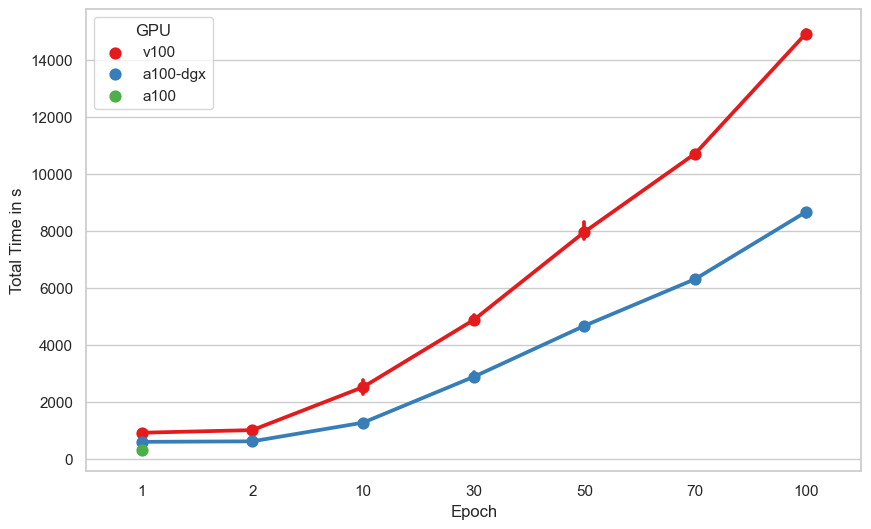

In [142]:
sns.set(style="whitegrid")

# Create a point plot using Seaborn
plt.figure(figsize=(10, 6))  # Optional: Set the figure size
sns.pointplot(x='epoch', y='total', hue='directive', data=df, palette='Set1')

# Add labels and legend
plt.xlabel('Epoch')
plt.ylabel('Total Time in s')
plt.legend(title='GPU')

# Show the plot
plt.show()


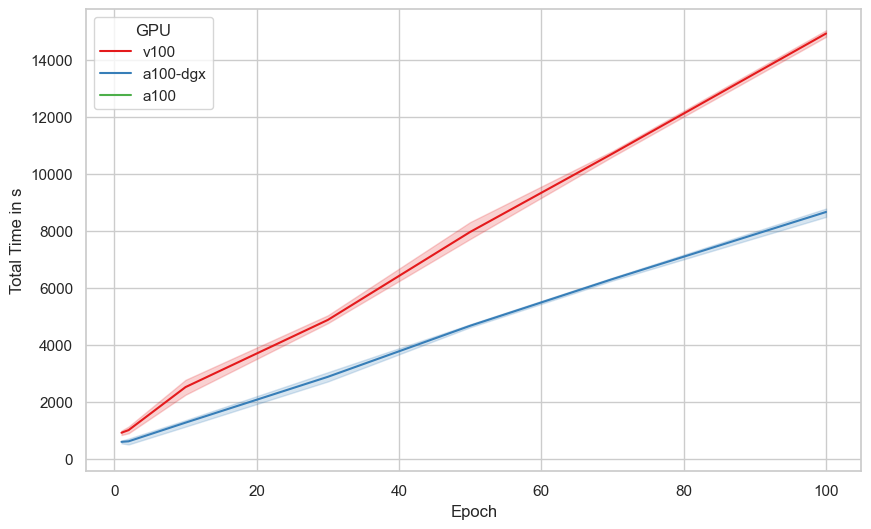

In [143]:

# Create a line plot using Seaborn
plt.figure(figsize=(10, 6))  # Optional: Set the figure size
plot = sns.lineplot(x='epoch', y='total', hue='directive', data=df, palette='Set1')

# Add labels
plt.xlabel('Epoch')
plt.ylabel('Total Time in s')

# Get the current legend
legend = plt.legend(title='Directive')

# Change the label in the legend
legend.set_title('GPU')

# Show the plot
plt.show()


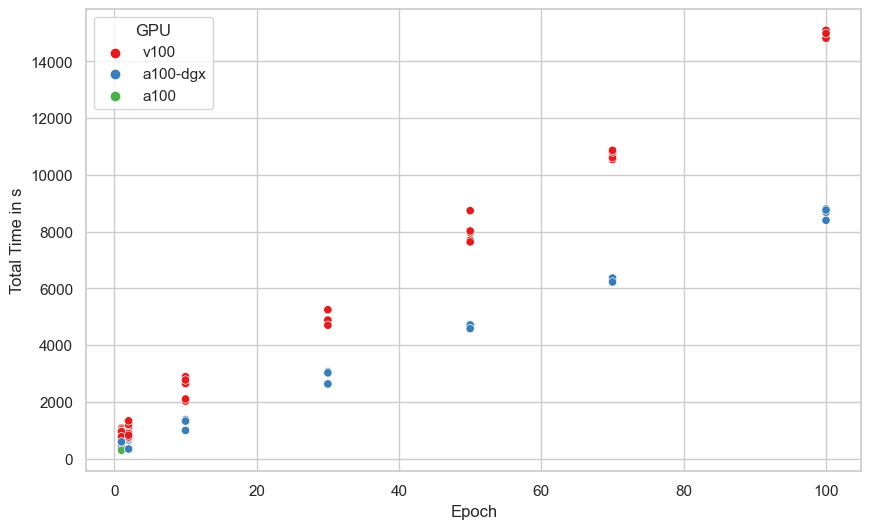

In [144]:

# Set the style of the plot
sns.set(style="whitegrid")

# Create a scatter plot using Seaborn
plt.figure(figsize=(10, 6))  # Optional: Set the figure size
sns.scatterplot(x='epoch', y='total', hue='directive', data=df, palette='Set1')

# Add labels and legend
plt.xlabel('Epoch')
plt.ylabel('Total Time in s')
plt.legend(title='GPU')

# Show the plot
plt.show()